In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import string, re
import gc # garbage collector to manage RAM usage
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
tweets = pd.read_csv('train.csv')
tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
# Rename columns to avoid clashes with the words in vocab later
tweets.rename(columns={'label':'Label', 'tweet':'Tweet'}, inplace=True) # TODO: Drop column 'id' from ‘tweets’ (Refer to pandas documentation)
...
# Check distribution of class of tweets
tweets.Label.value_counts()

0    29720
1     2242
Name: Label, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = \
  train_test_split(
    tweets['Tweet'],
    tweets['Label'],
    test_size=0.25,  # 20% of the data is test
    stratify=tweets['Label'],
    random_state=100)
# Combine the results into train and test dataframe
tweets_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
tweets_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
print(len(tweets_train))
print(len(tweets_test))
tweets_train.head()

23971
7991


,Tweet,Label
0,a week ago today i lost my cat and i found out...,0
1,retweets @user #nuascannan,0
2,@user my angel nicole. #niece #nicole #family...,0
3,@user @user @user still,0
4,"@user i don't wish an happy new year to a , an...",1


#Preprocessing

In [5]:
"""
    Tokenize tweets into words. Convert texts to lower case.
Remove hashtags, punctuations, stopwords, website links, extra spaces,
non-alphanumeric characters and single character. Lemmatize texts.
                                                                      """
nltk.download('stopwords')
nltk.download('wordnet')
def clean_tweet(tweet):
  twt_tokenizer = TweetTokenizer(strip_handles=True)
   # remove username handles
  tokens = [token for token in twt_tokenizer.tokenize(tweet)]
  # Combine stopwords and punctuation
  stops = stopwords.words("english") + list(string.punctuation)
   # Create lemmatizer
  lemmatizer = WordNetLemmatizer()
  tokens_no_hashtag = [re.sub(r'#', '', token) for token in tokens]
  tokens_no_stopwords = [token.lower() for token in tokens_no_hashtag if token.lower() not in stops]
  tokens_no_url = [re.sub(r'http\S+', '', token) for token in tokens_no_stopwords]
  tokens_no_url = [re.sub(r'www\S+', '', token) for token in tokens_no_url]
  tokens_no_extra_space = [re.sub(r'\s\s+', '', token) for token in tokens_no_url]
  tokens_alnum = [token for token in tokens_no_extra_space if
  token.isalnum()]
  tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_alnum]
  tokens_final = [token for token in tokens_lemma if len(token) > 1]
  return tokens_final

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
tweets_train['Tweet'] = tweets_train['Tweet'].apply(clean_tweet)
tweets_train.head()

,Tweet,Label
0,"[week, ago, today, lost, cat, found, time, day...",0
1,"[retweets, nuascannan]",0
2,"[angel, nicole, niece, nicole, familytime, tur...",0
3,[still],0
4,"[wish, happy, new, year, homophobic, warmonger...",1


# Create Vocabulory

In [7]:
vocab = []
for tweet in tweets_train['Tweet']:
  for word in tweet:
    vocab.append(word)
# vocab[:30]
vocab = list(set(vocab))
print(len(vocab))

31677


In [8]:
# Combine all the tweets into a single list
corpus = tweets_train['Tweet'].apply(lambda x:' '.join(x))
# Fit CountVectorizer
vectorizer = CountVectorizer()
X_train_wc = vectorizer.fit_transform(corpus)
X_train_wc

<23971x31677 sparse matrix of type '<class 'numpy.int64'>'
	with 174068 stored elements in Compressed Sparse Row format>

In [9]:
vocab_counts = pd.DataFrame(X_train_wc.toarray(), columns=vectorizer.get_feature_names_out())
# Concatenate vocab_counts with the original tweets_train dataframe
tweets_train = pd.concat([tweets_train, vocab_counts], axis=1)
tweets_train.head()

,Tweet,Label,000,003junior,0099,01,0161,01926889917,02,02668080,...,äº,çµ,èª,êµ,ëª,ðµð,ðµñ,ðº,ðºð,øª
0,"[week, ago, today, lost, cat, found, time, day...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[retweets, nuascannan]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[angel, nicole, niece, nicole, familytime, tur...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[still],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[wish, happy, new, year, homophobic, warmonger...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
del vocab_counts, corpus
gc.collect()

0

In [11]:
# P(hate) and P(non-hate)
p_hate = tweets_train['Label'].value_counts(normalize=True)[1]
p_nonhate= tweets_train['Label'].value_counts(normalize=True)[0]
print(p_hate, p_nonhate)

0.0701264027366401 0.9298735972633599


In [12]:
# Set smoothing parameter
alpha = 1
# N_hate
n_hate = tweets_train.loc[tweets_train['Label'] == 1, 'Tweet'].apply(len).sum()
# N_non_hate
n_nonhate = tweets_train.loc[tweets_train['Label'] == 0, 'Tweet'].apply(len).sum()
# N_vocab
n_vocab = len(vocab)

In [13]:
# Initialize dictionary to store conditional probability P(x|hate) and P(x|non-hate)
parameters_hate = {word:0 for word in vocab}
parameters_nonhate = {word:0 for word in vocab}
# Calculate conditional probability
for word in vocab:
  n_word_given_hate = tweets_train.loc[tweets_train['Label'] == 1, word].sum()
  n_word_given_nonhate = tweets_train.loc[tweets_train['Label'] == 0,word].sum()
  parameters_hate[word] = (n_word_given_hate + alpha) / (n_hate + alpha * n_vocab)
  parameters_nonhate[word] = (n_word_given_nonhate + alpha) / (n_nonhate + alpha * n_vocab)

In [14]:
def classify_new_tweet(tweet):
  final_tweet = clean_tweet(tweet)
  p_hateness = p_hate
  p_non_hateness = p_nonhate
  for token in final_tweet:
    if token in parameters_hate:
      p_hateness*=parameters_hate[token]
    if token in parameters_nonhate:
      p_non_hateness*=parameters_nonhate[token]
  if p_hateness > p_non_hateness:
    return 1
  else:
    return 0

In [15]:
tweets_test['Predicted_scratch'] = tweets_test['Tweet'].apply(classify_new_tweet)
tweets_test['Correct_scratch'] = (tweets_test['Label'] == tweets_test['Predicted_scratch'])
tweets_test.head()

,Tweet,Label,Predicted_scratch,Correct_scratch
0,i am thankful for employment. #thankful #posit...,0,0,True
1,@user cause today belongs to us ð one mis...,0,0,True
2,"@user don't forget his other incantation ""i've...",0,0,True
3,being #pios doesn't make you a better person e...,0,0,True
4,so chuffed to meet @user at surbiton. of cours...,0,0,True


In [16]:
tweets_test.head()

,Tweet,Label,Predicted_scratch,Correct_scratch
0,i am thankful for employment. #thankful #posit...,0,0,True
1,@user cause today belongs to us ð one mis...,0,0,True
2,"@user don't forget his other incantation ""i've...",0,0,True
3,being #pios doesn't make you a better person e...,0,0,True
4,so chuffed to meet @user at surbiton. of cours...,0,0,True


In [17]:
# Evaluate the model
total = len(tweets_test['Correct_scratch'])
ans = 0
for bo in tweets_test['Correct_scratch']:
  if bo:
    ans+=1
print(ans/total)

0.9612063571517958


In [18]:
tweets_test.head()

,Tweet,Label,Predicted_scratch,Correct_scratch
0,i am thankful for employment. #thankful #posit...,0,0,True
1,@user cause today belongs to us ð one mis...,0,0,True
2,"@user don't forget his other incantation ""i've...",0,0,True
3,being #pios doesn't make you a better person e...,0,0,True
4,so chuffed to meet @user at surbiton. of cours...,0,0,True


In [19]:
columns_to_drop = ['Predicted_scratch', 'Correct_scratch']
tweets_test = tweets_test.drop(columns=columns_to_drop)

#Exercise

In [20]:
# TODO: Convert y_train and y_test to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)
# Create X_test_wc using sklearn CountVectorizer
corpus = tweets_test['Tweet'].apply(lambda x:' '.join(x))
# TODO: Refer to scikit learn documentation and use an appropriate method on the corpus, to determine X_test_wc matrix
X_test_wc = vectorizer.transform(corpus)
# Ensure the shape of X, y in training and test set is correct
print("Shape of X_train: {}".format(X_train_wc.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test_wc.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (23971, 31677)
Shape of y_train: (23971,)
Shape of X_test: (7991, 31677)
Shape of y_test: (7991,)


In [21]:
clf = MultinomialNB()# default smoothing parameter alpha = 1
clf.fit(X_train_wc, y_train)# TODO: Pass appropriate parameters to fit for training
clf.score(X_test_wc, y_test)# TODO: Pass appropriate parameters for evaluating (test)

0.9297960205230885

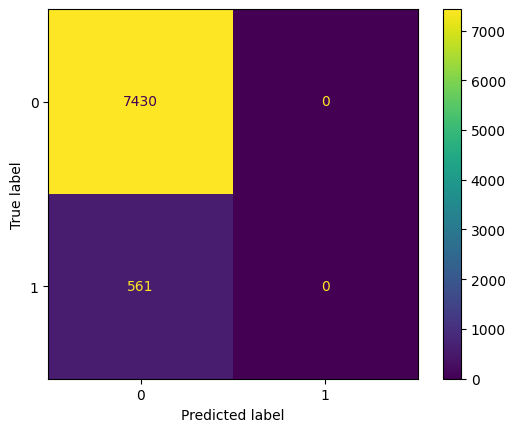

In [22]:
# Generate confusion matrix plot
y_pred = clf.predict(X_test_wc)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [28]:
print(cm[1][0])
print(cm[1][1])
print(cm[0][0])
print(cm[0][1])

561
0
7430
0


In [33]:
from nltk.metrics.scores import precision
def evaluate(confusion_matrix):
# TODO: Using the definitions given before, determine each of the metrics
  FN = confusion_matrix[1][0]
  FP = confusion_matrix[0][1]
  TP = confusion_matrix[1][1]
  TN = confusion_matrix[0][0]
  if TP+FP!=0 :
    precision = TP/(TP + FP)
  else:
    precision = 0

  if TP+FN!=0 :
    recall = TP/(TP + FN)
    sensitivity = TP/(TP + FN)
  else:
    recall = 0
    sensitivity = 0

  if TN+FP!=0 :
    specificity = TN/(TN + FP)
  else:
    specificity = 0

  if TN+FP+TP+FN!=0 :
    accuracy = (TN+TP)/(TN + FP+TP+FN)
  else:
    accuracy = 0

  if precision+recall!=0 :
    f1_score = (2*precision*recall)/(precision+recall)
  else:
    f1_score = 0



  metrics = {
      'Precision': precision,
      'Recall': recall,
      'Sensitivity': sensitivity,
      'Specificity': specificity,
      'Accuracy': accuracy,
      'F1-Score': f1_score
  }
  return metrics
"""
Evaluate classification performance metrics based on a confusion matrix.
Args:
confusion_matrix (list of lists): A 2x2 confusion matrix in the
following format:
[[true_negative, false_positive],
             [false_negative, true_positive]]
Returns:
dict: A dictionary containing precision, recall, sensitivity,
specificity, accuracy, and F1-Score.
"""


'\nEvaluate classification performance metrics based on a confusion matrix.\nArgs:\nconfusion_matrix (list of lists): A 2x2 confusion matrix in the\nfollowing format:\n[[true_negative, false_positive],\n             [false_negative, true_positive]]\nReturns:\ndict: A dictionary containing precision, recall, sensitivity,\nspecificity, accuracy, and F1-Score.\n'

In [34]:
matric = evaluate(cm)
matric

{'Precision': 0,
 'Recall': 0.0,
 'Sensitivity': 0.0,
 'Specificity': 1.0,
 'Accuracy': 0.9297960205230885,
 'F1-Score': 0}